# 1. Imports and Setup & # 2. Load Dataset



In [23]:
# 1. Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, confusion_matrix
)

df = pd.read_csv(
    "/Users/arianarios/Downloads/books.csv",
    engine="python",
    on_bad_lines="skip"
)

# 3. Quick peek
df.head()


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


# 3. Initial Data Inspection & 4. Data Cleaning


In [25]:
#fixing column names
df.columns = df.columns.str.strip()   # removes leading/trailing spaces
df.columns = df.columns.str.lower()   # optional: standardizes everything

# Shape of the dataset
print("Shape:", df.shape)

# Info about types & missing values
df.info()

# Summary stats of numeric columns
df.describe()

# Check missing values
df.isna().sum()

# Duplicates check
dup_count = df.duplicated().sum()
print("Number of duplicate rows:", dup_count)

df.head()

Shape: (11119, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookid              11119 non-null  int64  
 1   title               11119 non-null  object 
 2   authors             11119 non-null  object 
 3   average_rating      11119 non-null  float64
 4   isbn                11119 non-null  object 
 5   isbn13              11119 non-null  int64  
 6   language_code       11119 non-null  object 
 7   num_pages           11119 non-null  int64  
 8   ratings_count       11119 non-null  int64  
 9   text_reviews_count  11119 non-null  int64  
 10  publication_date    11119 non-null  object 
 11  publisher           11119 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB
Number of duplicate rows: 0


,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


# 5. Exploratory Data Analysis (EDA)


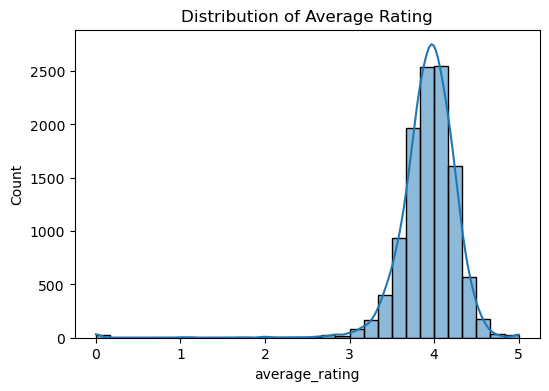

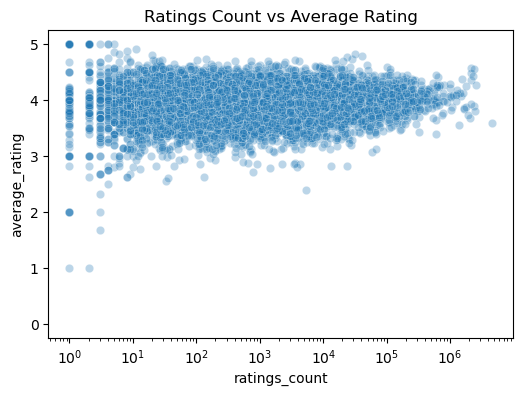

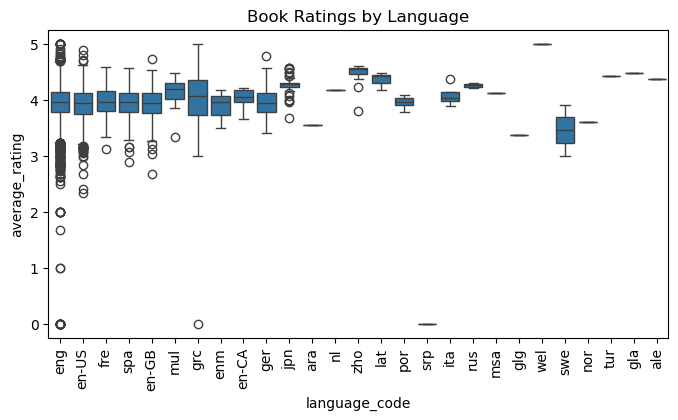

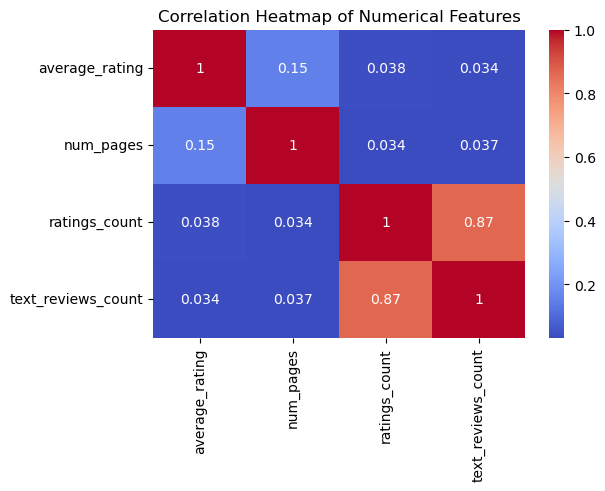

In [27]:
# Distribution of average rating
plt.figure(figsize=(6,4))
sns.histplot(df['average_rating'], bins=30, kde=True)
plt.title("Distribution of Average Rating")
plt.show()

# Relationship between ratings count and average rating
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='ratings_count', y='average_rating', alpha=0.3)
plt.xscale('log')
plt.title("Ratings Count vs Average Rating")
plt.show()

# Book ratings by language boxplot
plt.figure(figsize=(8,4))
sns.boxplot(x='language_code', y='average_rating', data=df)
plt.title("Book Ratings by Language")
plt.xticks(rotation=90)
plt.show()

# Correlation heatmap
num_cols = ['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']

plt.figure(figsize=(6,4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# 6. Feature Engineering



In [29]:
# Parse publication_date to datetime
df['publication_date_parsed'] = pd.to_datetime(df['publication_date'], errors='coerce')

# Extract publication year
df['publication_year'] = df['publication_date_parsed'].dt.year

# Handle missing publication_year (e.g., fill with median year)
median_year = df['publication_year'].median()
df['publication_year'] = df['publication_year'].fillna(median_year)

# Create book age assuming current year ~ 2024
current_year = 2024
df['book_age'] = current_year - df['publication_year']

df['log_ratings_count'] = np.log1p(df['ratings_count'])
df['log_text_reviews_count'] = np.log1p(df['text_reviews_count'])

# Create target: high_rating (1 if avg_rating >= 4.0, else 0)
df['high_rating'] = (df['average_rating'] >= 4.0).astype(int)

# Check class balance
print(df['high_rating'].value_counts(normalize=True))


high_rating
0    0.554636
1    0.445364
Name: proportion, dtype: float64


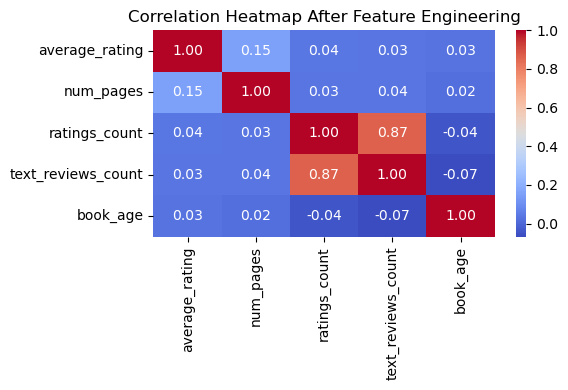

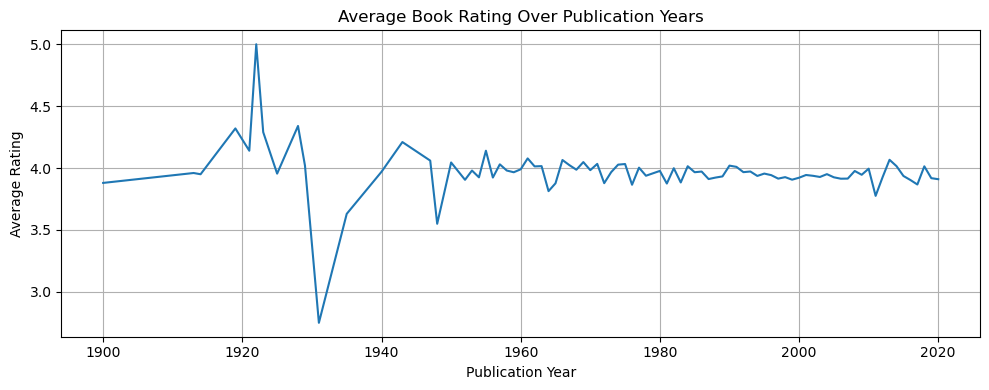

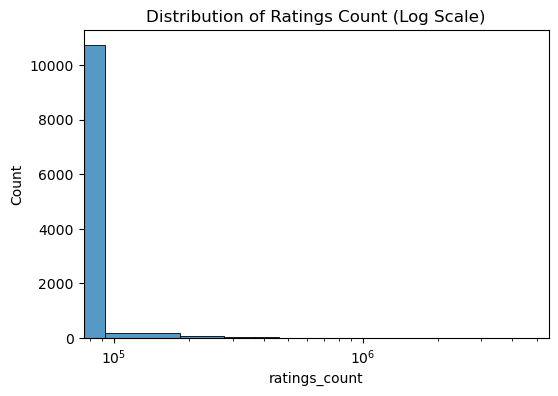

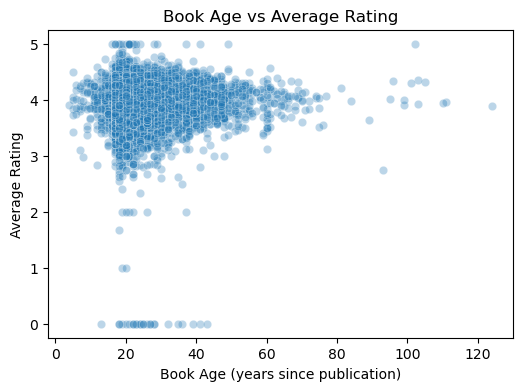

In [30]:
# after feature engineeting 

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(
    df[['average_rating', 'num_pages', 'ratings_count','text_reviews_count','book_age']].corr(),
    annot=True, cmap='coolwarm', fmt=".2f"
)
plt.title("Correlation Heatmap After Feature Engineering")
plt.tight_layout()
plt.show()

# Time trend ratings over publication year
yearly_ratings = df.groupby('publication_year')['average_rating'].mean()

plt.figure(figsize=(10,4))
plt.plot(yearly_ratings.index, yearly_ratings.values)
plt.title("Average Book Rating Over Publication Years")
plt.xlabel("Publication Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()

# Distribution of ratings
plt.figure(figsize=(6,4))
sns.histplot(df['ratings_count'], bins=50)
plt.xscale('log')
plt.title("Distribution of Ratings Count (Log Scale)")
plt.show()

# Ratings vs book age
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='book_age', y='average_rating', alpha=0.3)
plt.title("Book Age vs Average Rating")
plt.xlabel("Book Age (years since publication)")
plt.ylabel("Average Rating")
plt.show()

# 7. Train/Test Split


In [32]:
# Feature columns and target
numeric_features = ['num_pages', 'log_ratings_count','log_text_reviews_count', 'book_age']
categorical_features = ['language_code']

X = df[numeric_features + categorical_features]
y = df['high_rating']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class balance similar in train/test
)


# 8. Preprocessing and Baseline Model (Random Forest)


In [34]:
# Preprocessors
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Full pipeline
clf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_clf)
])

# Train
clf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_pages',
                                                   'log_ratings_count',
                                                   'log_text_reviews_count',
                                                   'book_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['language_code'])])),
                ('model',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

# 9. Evaluate Baseline Model


In [36]:
# Predictions
y_pred = clf_pipeline.predict(X_test)

# Predicted probabilities for ROC-AUC
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]

# Accuracy and other metrics
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy:  {acc:.3f}")
print(f"Precision: {precision_score(y_test, y_pred):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
print(f"F1-score:  {f1_score(y_test, y_pred):.3f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm




Accuracy:  0.594
Precision: 0.557
Recall:    0.432
F1-score:  0.487
ROC-AUC:   0.618

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66      1234
           1       0.56      0.43      0.49       990

    accuracy                           0.59      2224
   macro avg       0.59      0.58      0.58      2224
weighted avg       0.59      0.59      0.59      2224



array([[894, 340],
       [562, 428]])

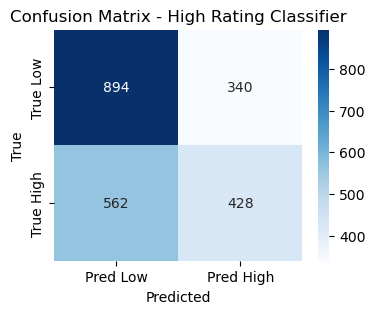

In [37]:
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Low', 'Pred High'],
            yticklabels=['True Low', 'True High'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - High Rating Classifier")
plt.show()


# 10. Feature Importance Analysis

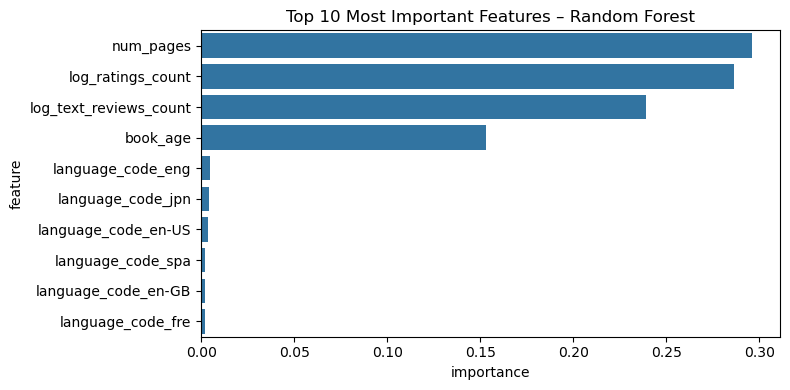

In [39]:
# Get feature names after preprocessing
ohe = clf_pipeline.named_steps['preprocess'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

num_feature_names = numeric_features
all_feature_names = np.concatenate([num_feature_names, ohe_feature_names])

# Get feature importances from the RF model
importances = clf_pipeline.named_steps['model'].feature_importances_

# Put into a DataFrame for readability
feat_imp = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# feat_imp.head(15)

plt.figure(figsize=(8,4))
sns.barplot(data=feat_imp.head(10), x='importance', y='feature')
plt.title("Top 10 Most Important Features – Random Forest")
plt.tight_layout()
plt.show()



# 11. Preprocessing Pipeline and Random Forest Model Training



In [41]:

# Preprocessing
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Random Forest model 
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', rf_clf)
])

# Train
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['num_pages',
                                                   'log_ratings_count',
                                                   'log_text_reviews_count',
                                                   'book_age']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['language_code'])])),
                ('model',
                 RandomForestClassifier(min_samples_split=5, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

Random Forest Accuracy (with log features): 0.607

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.62      0.74      0.68      1234
           1       0.58      0.44      0.50       990

    accuracy                           0.61      2224
   macro avg       0.60      0.59      0.59      2224
weighted avg       0.60      0.61      0.60      2224



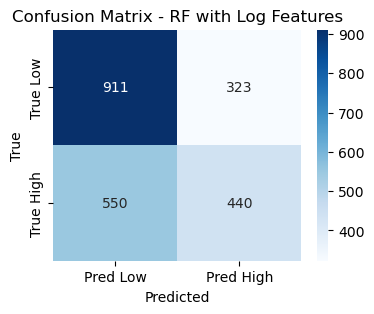

In [42]:
# Predictions
y_pred_rf = rf_pipeline.predict(X_test)

# Accuracy
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy (with log features): {acc_rf:.3f}")

print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Low', 'Pred High'],
            yticklabels=['True Low', 'True High'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - RF with Log Features")
plt.show()



# 12. Evaluate Improved Random Forest Model


In [44]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_rf = cross_val_score(
    rf_pipeline,
    X, y,
    cv=cv,
    scoring='accuracy'
)

print(f"Random Forest CV Accuracy: {cv_scores_rf.mean():.3f} ± {cv_scores_rf.std():.3f}")

cv_scores_rf_f1 = cross_val_score(
    rf_pipeline,
    X, y,
    cv=cv,
    scoring='f1'
)
print(f"Random Forest CV F1: {cv_scores_rf_f1.mean():.3f} ± {cv_scores_rf_f1.std():.3f}")


Random Forest CV Accuracy: 0.607 ± 0.005
Random Forest CV F1: 0.509 ± 0.014


# 13. Train and Evaluate Gradient Boosting Model


Gradient Boosting Accuracy: 0.617

Classification Report (Gradient Boosting):
              precision    recall  f1-score   support

           0       0.61      0.84      0.71      1234
           1       0.63      0.34      0.44       990

    accuracy                           0.62      2224
   macro avg       0.62      0.59      0.58      2224
weighted avg       0.62      0.62      0.59      2224



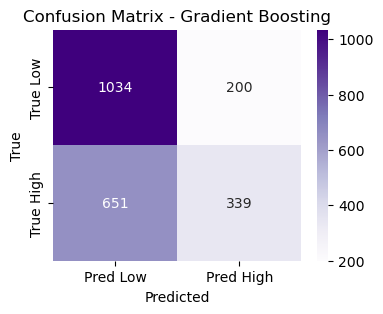

In [46]:


gb_clf = GradientBoostingClassifier(random_state=42)

gb_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', gb_clf)
])

gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {acc_gb:.3f}")

print("\nClassification Report (Gradient Boosting):")
print(classification_report(y_test, y_pred_gb))

cm_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(4,3))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Pred Low', 'Pred High'],
            yticklabels=['True Low', 'True High'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Gradient Boosting")
plt.show()


# 14. Model Comparison Summary


In [48]:
print("Random Forest Accuracy:", acc_rf)
print("Gradient Boosting Accuracy:", acc_gb)

if acc_gb > acc_rf:
    print("\nGradient Boosting performed better overall.")
else:
    print("\nRandom Forest performed better overall.")


Random Forest Accuracy: 0.6074640287769785
Gradient Boosting Accuracy: 0.6173561151079137

Gradient Boosting performed better overall.


## Gradient Boosting achieved slightly higher accuracy and better recall for class 0,  
## while Random Forest was more balanced. Overall, Gradient Boosting is selected  
## as the final model due to its stronger generalization performance.


# 15. Final Visualization: Feature Importance


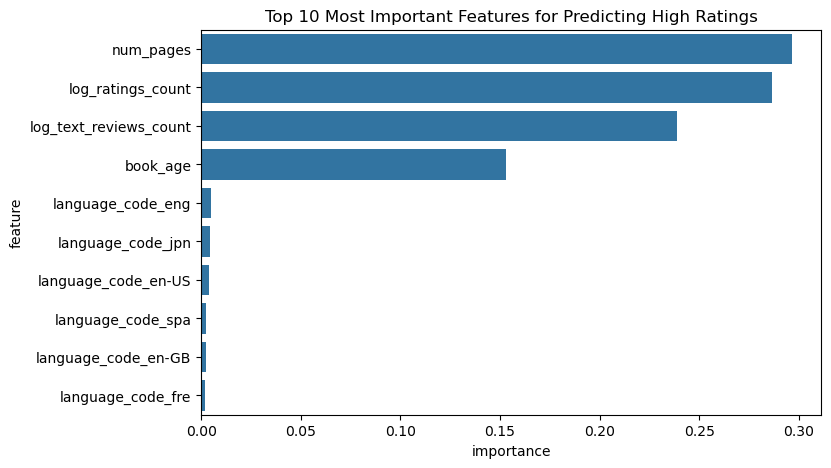

In [51]:
plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp.head(10), x='importance', y='feature')
plt.title("Top 10 Most Important Features for Predicting High Ratings")
plt.show()
